# Avance 1 — EDA de Casos de Prueba (Cotizaciones/Pedidos)
**Equipo:** 3 • **Fecha:** 2025-09-29

Metricas en este Notebook: univariante (histos/boxplots), categóricas (barras),
bi/multivariante (correlación numérica + crosstab + Cramér’s V), preprocesamiento (faltantes, outliers, cardinalidad),
selección de características (2.1) para recuperación (TF-IDF + SVD con **fix robusto**), y export limpio.


# Resumen ejecutivo (alcance ajustado)

Tras una reunión con asesores de IBM, se reduce el alcance del Proyecto Integrador para enfocarlo en el proyecto más relevante de Castor (metalurgia para construcción). En esta entrega solo se trabaja en Regression Test Selection (RTS) y, si el tiempo lo permite, en un asistente de Pull Request (PR) con IBM Watson. El resto de componentes queda como trabajo futuro.

## Nombre del proyecto

Servicio de calidad aumentada por IA

## Contexto de la empresa

Castor (Medellín, Colombia) desarrolla software y UX/UI. Para este PI se centra exclusivamente en metalurgia para construcción, por ser el proyecto de mayor impacto.

## Alcance actual (máximo entregable de esta entrega)

Disparo por PR (simulado): La creación de un PR activa el pipeline CI/CD y registra metadatos (Jira/Azure DevOps, simulado).

Integración con IBM (por definir servicios): El pipeline envía datos del cambio de código a IBM Cloud para su procesamiento.

Modelo de RTS: Un modelo selecciona el subconjunto óptimo de casos de prueba a ejecutar a partir de archivos modificados y características del cambio.

Asistente de PR (opcional, si alcanza): Agente basado en IBM Watson (p.ej., Discovery + RAG) para resúmenes/sugerencias sobre el PR usando documentación interna.

## Fuera de alcance en esta entrega (quedará como futuro/simulado)

Ejecución real + retroalimentación: resultados, detección de flaky tests y reentrenamiento.

Publicación consolidada en el PR (análisis estático, riesgo de defectos, resultados y sugerencias) y actualización en Jira/Azure DevOps.

Dashboard DORA para monitoreo estratégico.

Modelo de evaluación de riesgo de cambios (queda para fase posterior).

## 0) Configuración y carga de datos

In [14]:
from __future__ import annotations
import re, json, sys, time, platform, hashlib, warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.figsize": (8,5)})

@dataclass
class Config:
    # Paths
    RAW_TESTS: Path = Path("../data/raw/TestCases.csv")
    RAW_CHANGED: Path = Path("../data/raw/ChangedFiles.csv")
    RAW_META: Path = Path("../data/raw/PipelineMeta.csv")
    OUT_DIR: Path = Path("../data/processed")
    RUN_DIR: Path = Path("../run_artifacts")
    # Behavior
    MAKE_PLOTS: bool = True
    USE_SVD: bool = False           # Desactivado: RTS no lo requiere (reduce tiempo/memoria)
    TOP_FRACTION: float = 0.15      # % de tests a seleccionar por PR
    TFIDF_MAX_FEATURES: int = 6000  # Dim TF-IDF
    LINES_NORM: int = 300           # Normalizador de tamaño de cambio
    # Pesos del score RTS
    W_SIM: float = 0.6
    W_MODULE: float = 0.2
    W_RISK: float = 0.1
    W_SIZE: float = 0.1

CFG = Config()
assert CFG.RAW_TESTS.exists(), f"No se encontró {CFG.RAW_TESTS}"
assert CFG.RAW_CHANGED.exists(), f"No se encontró {CFG.RAW_CHANGED}"
assert CFG.RAW_META.exists(), f"No se encontró {CFG.RAW_META}"
CFG.OUT_DIR.mkdir(parents=True, exist_ok=True)
CFG.RUN_DIR.mkdir(parents=True, exist_ok=True)


## 1) UTILIDADES: hashing, casting, gráficos

In [15]:
def sha256(path: Path) -> str | None:
    if not path.exists(): return None
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def to_numeric(series: pd.Series) -> pd.Series:
    # vectorizado: cambia coma decimal y convierte; errores -> NaN
    return pd.to_numeric(series.astype(str).str.replace(",", ".", regex=False), errors="coerce")

def bar(series: pd.Series, title: str, xlabel: str):
    ax = series.plot(kind="bar")
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel("conteo")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

def hist(series: pd.Series, title: str, xlabel: str, bins=30):
    series.plot(kind="hist", bins=bins, alpha=0.85)
    plt.title(title); plt.xlabel(xlabel); plt.tight_layout(); plt.show()


## 2) CARGA + NORMALIZACIÓN (vectorizado)

In [16]:
ALIAS: Dict[str, List[str]] = {
    "case_id": ["case_id","id","Id","ID","codigo","código","id caso","id_cp","id cp"],
    "title": ["title","titulo","título","nombre cp","nombre_cp","nombre del caso","nombre","NOMBRE CP","NOMBRE"],
    "preconditions": ["preconditions","precondiciones","pre-condiciones","precondición","precondicion","precondiciones cp","Precondición"],
    "steps": ["steps","pasos","procedimiento","instrucciones","PASOS"],
    "expected_result": ["expected_result","resultado_esperado","resultado esperado","RESULTADO ESPERADO"],
    "obtained_result": ["obtained_result","resultado_obtenido","resultado obtenido","RESULTADO OBTENIDO"],
    "observations": ["observations","observaciones","notas","OBSERVACIONES"],
    "exec_count": ["# ejec","num_ejec","num ejec","ejecuciones","# ejecuciones","# EJEC","#EJEC"],
    "test_status": ["estado de la prueba","estado_prueba","resultado","estado","TEST STATUS","Estado de la prueba"],
    "feature_name": ["nombre de la funcionalidad","funcionalidad","feature","Nombre de la funcionalidad"],
    "sprint": ["sprint","iteracion","iteración","SPRINT"],
    "created_at": ["fecha de creación","fecha_creacion","creado","Fecha de creación"],
    "module": ["module","módulo","modulo","area","área","component","componente","modulo funcional"],
    "type": ["type","tipo","categoria","category","tipo de prueba","tipo prueba","clase de prueba"],
    "priority": ["priority","prioridad","severity","severidad"],
    "estimated_duration_min": ["estimated_duration_min","duracion_min","duración_min","duration","duracion","duración"],
}

TEXT_COLS = ["title","preconditions","steps","expected_result","obtained_result","observations"]

def rename_by_alias(df: pd.DataFrame, alias: Dict[str, List[str]]) -> pd.DataFrame:
    lower_map = {c.lower(): c for c in df.columns}
    rename_map = {}
    for std, options in alias.items():
        for opt in options:
            col = lower_map.get(opt.lower())
            if col:
                rename_map[col] = std; break
    return df.rename(columns=rename_map)

def load_and_clean_tests(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = rename_by_alias(df, ALIAS)

    # Texto: fillna y trim vectorizado
    for c in [x for x in TEXT_COLS + ["feature_name"] if x in df.columns]:
        df[c] = df[c].fillna("").astype(str).str.strip()

    # Categóricas: trim (y opcionalmente convertir a 'category' para memoria)
    for c in [x for x in ["module","type","priority","test_status","sprint"] if x in df.columns]:
        df[c] = df[c].astype(str).str.strip()

    # Numéricas
    if "exec_count" in df.columns:
        df["exec_count"] = to_numeric(df["exec_count"]).astype("float")
    if "estimated_duration_min" in df.columns:
        df["estimated_duration_min"] = to_numeric(df["estimated_duration_min"]).astype("float")

    # Duplicados exactos (rápido, estable)
    df = df.drop_duplicates()

    # Longitudes (vectorizado)
    for c in [x for x in TEXT_COLS if x in df.columns]:
        df[f"{c}_len"] = df[c].str.len()

    return df

df = load_and_clean_tests(CFG.RAW_TESTS)
print("Shape:", df.shape)
display(df.head(4))

Shape: (288, 19)


,case_id,title,preconditions,steps,expected_result,obtained_result,observations,exec_count,test_status,feature_name,sprint,created_at,module,title_len,preconditions_len,steps_len,expected_result_len,obtained_result_len,observations_len
0,1-HU1-1,Visualización de la opción 'Cotización' en el ...,Haber accedido al 'Portal de Clientes',"1) Filtrar el cliente por RNC, nombre o Código...",La opción 'Cotización' aparece correctamente e...,La opción 'Cotización' aparece correctamente e...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,102,38,200,66,66,0
1,1-HU1-2,Redirección a la página de Cotizaciones al hac...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,El usuario es redirigido correctamente a la pá...,El usuario es redirigido correctamente a la pá...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,69,75,59,67,67,0
2,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,La página de Cotizaciones carga correctamente ...,La página de Cotizaciones no carga correctamen...,La página se tarda en cargar,2.0,Falló en su ejecución,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,55,75,59,87,90,28
3,1-HU1-4,Contenido correcto en la página de Cotizacione...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,El contenido de la página de Cotizaciones es v...,El contenido de la página de Cotizaciones es v...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,67,75,113,64,64,0


##  3) STATUS + MÓDULO INFERIDO (sin apply row-wise)

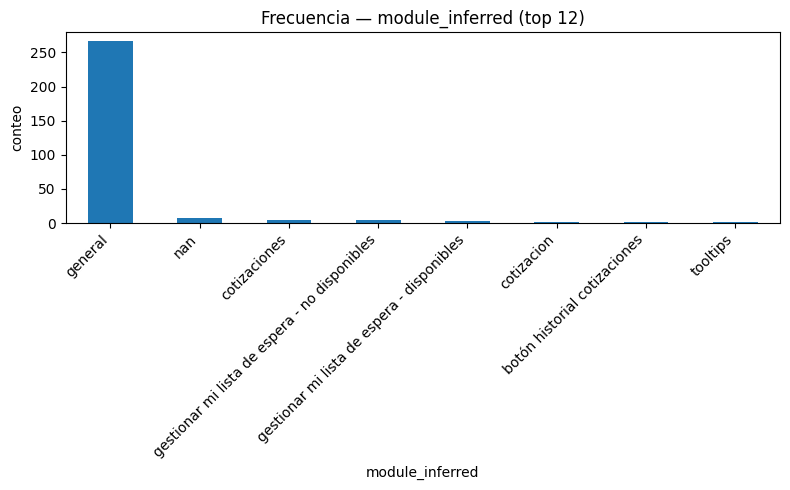

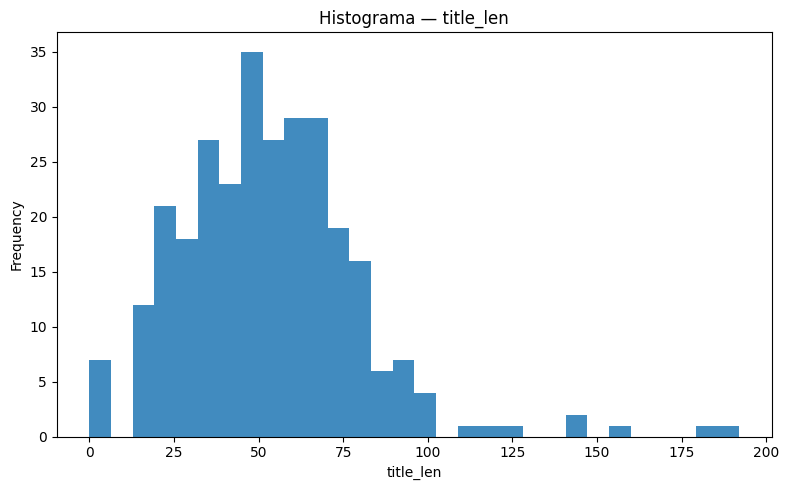

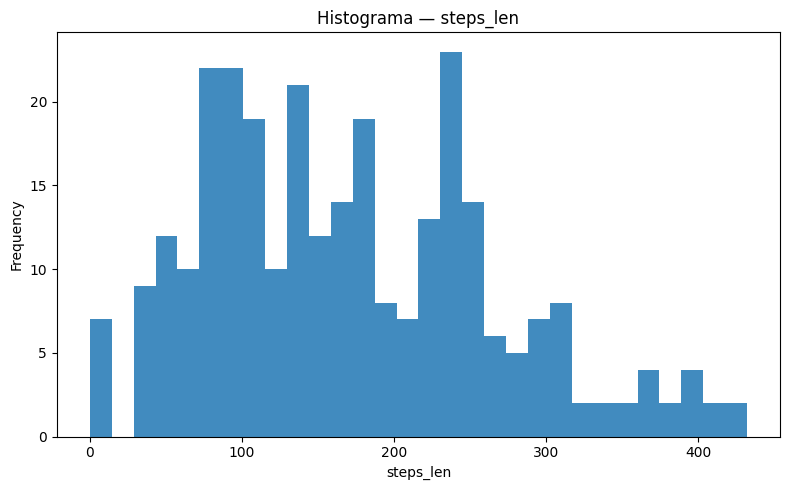

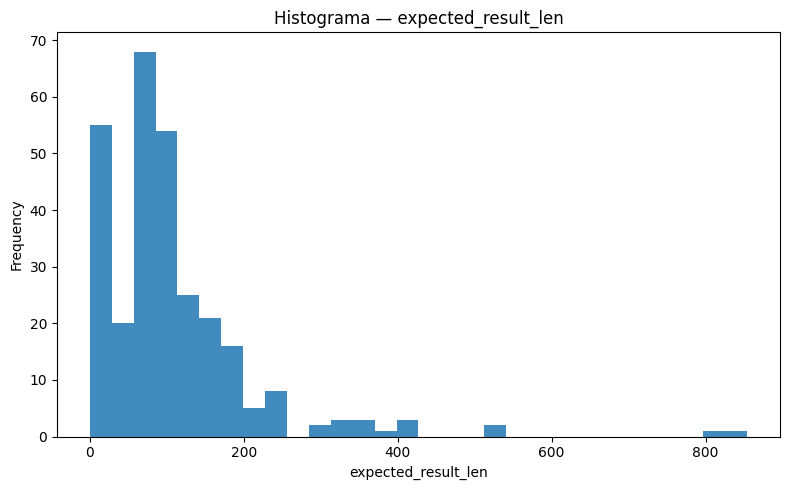

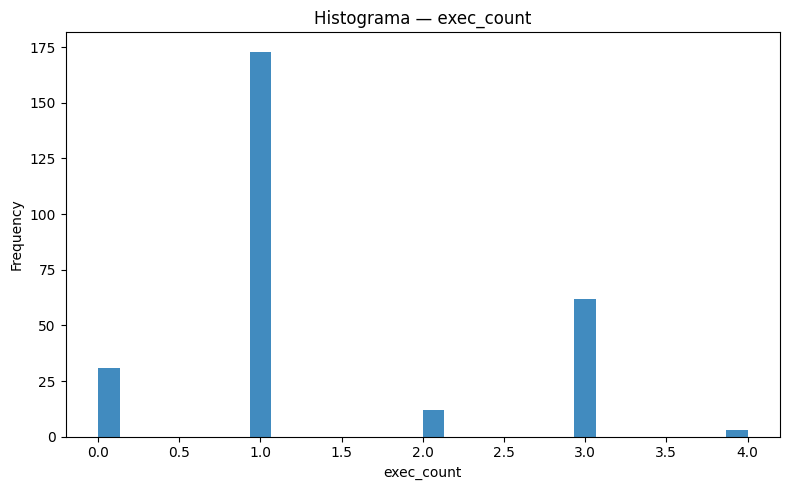

In [17]:
STATUS_MAP = {
    "ejecución exitosa":"pass","ejecucion exitosa":"pass","ok":"pass","exitoso":"pass","exitosamente":"pass",
    "falló en su ejecución":"fail","fallo en su ejecucion":"fail","falló":"fail","fail":"fail","no cumple":"fail",
    "no se ejecutó":"not_run","no se ejecuto":"not_run","pendiente":"not_run",
    "el componente no esta listo":"blocked","bloqueada":"blocked","bloqueado":"blocked"
}

def normalize_status_col(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).str.strip().str.lower()
    mapped = s.map(STATUS_MAP)

    mask_unset = mapped.isna()

    mapped.loc[mask_unset & s.str.contains(r"(exitosa|exitos|^ok$)", regex=True)] = "pass"
    mapped.loc[mask_unset & s.str.contains(r"(fall|error)", regex=True)]           = "fail"
    mapped.loc[mask_unset & s.str.contains(r"(no se ejec|pend)", regex=True)]     = "not_run"
    mapped.loc[mask_unset & s.str.contains(r"(bloque|no est[aá] listo)", regex=True)] = "blocked"

    return mapped


df["status_std"] = normalize_status_col(df["test_status"]) if "test_status" in df.columns else np.nan

def infer_module_fast(df: pd.DataFrame) -> pd.Series:
    # Texto agregado para heurística
    base = (
        df.get("module", "").astype(str).str.lower().str.strip() + " " +
        df.get("feature_name", "").astype(str).str.lower() + " " +
        df.get("title", "").astype(str).str.lower() + " " +
        df.get("steps", "").astype(str).str.lower()
    )
    conds = [
        base.str.contains("cotizacion|cotización|cotizaciones", regex=True),
        base.str.contains(r"\bpedido(s)?\b", regex=True),
        base.str.contains("precio(s)?", regex=True),
        base.str.contains("impuesto(s)?", regex=True),
        base.str.contains("cliente(s)?", regex=True),
    ]
    choices = ["cotizaciones","pedidos","precios","impuestos","clientes"]
    inferred = np.select(conds, choices, default="otros")
    # prioriza 'module' explícito si existe
    module_explicit = df.get("module")
    if module_explicit is not None:
        m = module_explicit.astype(str).str.lower().str.strip()
        inferred = np.where(m.ne(""), m, inferred)
    return pd.Series(inferred, index=df.index)

df["module_inferred"] = infer_module_fast(df)

# Gráficos mínimos útiles para RTS
if CFG.MAKE_PLOTS:
    bar(df["module_inferred"].value_counts().head(12), "Frecuencia — module_inferred (top 12)", "module_inferred")
    for c in [x for x in ["title_len","steps_len","expected_result_len","exec_count"] if x in df.columns]:
        hist(df[c].dropna(), f"Histograma — {c}", c, bins=30)


## 4) OUTLIERS LIGEROS

In [18]:
if "estimated_duration_min" in df.columns:
    q01, q99 = df["estimated_duration_min"].quantile([0.01, 0.99])
    df["estimated_duration_min"] = df["estimated_duration_min"].clip(q01, q99)
    if df["estimated_duration_min"].skew() > 1:
        df["estimated_duration_min_log1p"] = np.log1p(df["estimated_duration_min"])


## 5) TEXTO COMPLETO (1 pasada)

In [19]:
for c in TEXT_COLS:
    if c not in df.columns: df[c] = ""
df["text_full"] = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)

# Guardado básico de features limpias (útil para auditoría)
keep_cols = [
    "case_id","title","preconditions","steps","expected_result","obtained_result","observations",
    "feature_name","sprint","created_at",
    "module","module_inferred","type","priority","exec_count","test_status","status_std",
    "estimated_duration_min","estimated_duration_min_log1p",
    "title_len","steps_len","expected_result_len","obtained_result_len","preconditions_len","observations_len",
]
keep_cols = [c for c in keep_cols if c in df.columns]
df[keep_cols + ["text_full"]].to_csv(CFG.OUT_DIR / "TestCases_clean_features.csv", index=False)


## 6) DATOS DEL PR (ChangedFiles + PipelineMeta) => documento por PR

In [20]:
cf = pd.read_csv(CFG.RAW_CHANGED)
pm = pd.read_csv(CFG.RAW_META)

for f in (cf, pm):
    for c in f.columns:
        if f[c].dtype == "O":
            f[c] = f[c].astype(str).str.strip()

def path_tokens(path: str) -> str:
    s = re.sub(r"[^a-zA-Z0-9_/.\-]", " ", str(path))
    parts = re.split(r"[/_.\-]+", s.lower())
    parts = [p for p in parts if p and len(p) > 1]
    return " ".join(parts)

pr_docs = (
    cf.assign(file_tokens=cf["file_path"].map(path_tokens))
      .groupby("pr_id")
      .agg(file_tokens=("file_tokens", " ".join),
           modules_str=("module", lambda s: " ".join(map(str, s))),
           lines_added=("lines_added","sum"),
           lines_deleted=("lines_deleted","sum"))
      .join(pm.set_index("pr_id")[["pr_title","pr_desc","severity_declared","has_db_migration","changed_files"]], how="left")
      .fillna({"pr_title":"","pr_desc":"","modules_str":"","file_tokens":""})
)

pr_docs["pr_text"] = pr_docs["pr_title"]+" "+pr_docs["pr_desc"]+" "+pr_docs["file_tokens"]+" "+pr_docs["modules_str"]
pr_docs["total_lines_changed"] = (pr_docs["lines_added"].fillna(0) + pr_docs["lines_deleted"].fillna(0)).astype(int)
display(pr_docs.head(4))


,file_tokens,modules_str,lines_added,lines_deleted,pr_title,pr_desc,severity_declared,has_db_migration,changed_files,pr_text,total_lines_changed
pr_id,,,,,,,,,,,
PR-1001,services precios taxes py api cotizaciones end...,cotizaciones cotizaciones cotizaciones,240,55,Ajuste cálculo de precios por IVA diferenciado,Se corrige el cálculo de impuestos para cotiza...,normal,no,3,Ajuste cálculo de precios por IVA diferenciado...,295
PR-1002,services pedidos validator py db migrations 20...,pedidos pedidos pedidos,115,38,Fix validación de clientes al crear pedido,Se agrega validación estricta y se crea índice...,critical,yes,3,Fix validación de clientes al crear pedido Se ...,153
PR-1003,ui clientes searchbar tsx services clientes re...,clientes clientes,45,17,Optimización de búsqueda de clientes,Se mejora la búsqueda por RNC y nombre y se re...,normal,no,2,Optimización de búsqueda de clientes Se mejora...,62


## 7) RTS CORE: vectorización conjunta + score rápido (sin bucles)

[RTS] PR-1001: top 43/288 | umbral=0.1644 -> ..\data\processed\RTS_selected_PR-1001.csv
[RTS] PR-1002: top 43/288 | umbral=0.1693 -> ..\data\processed\RTS_selected_PR-1002.csv


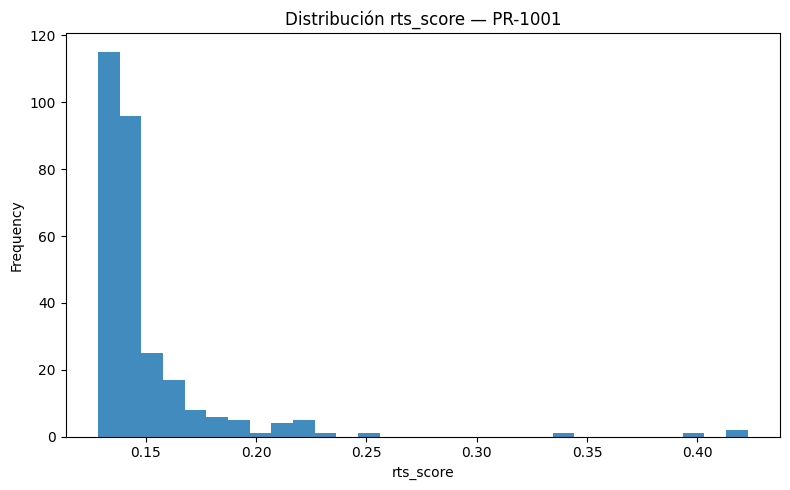

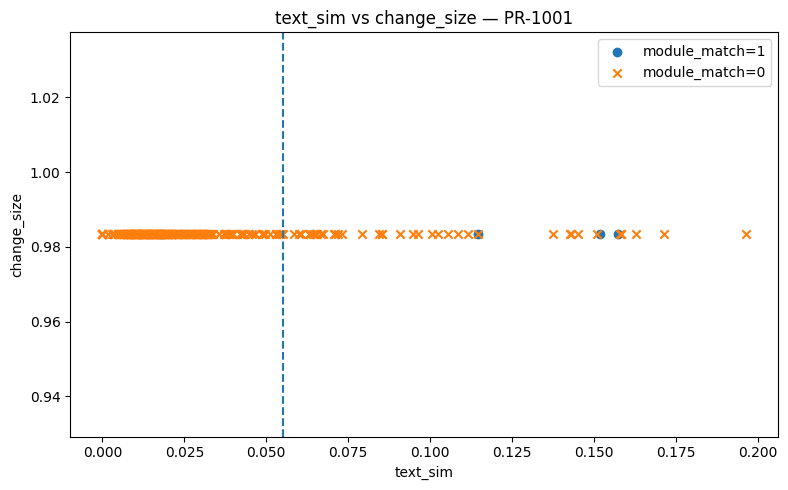

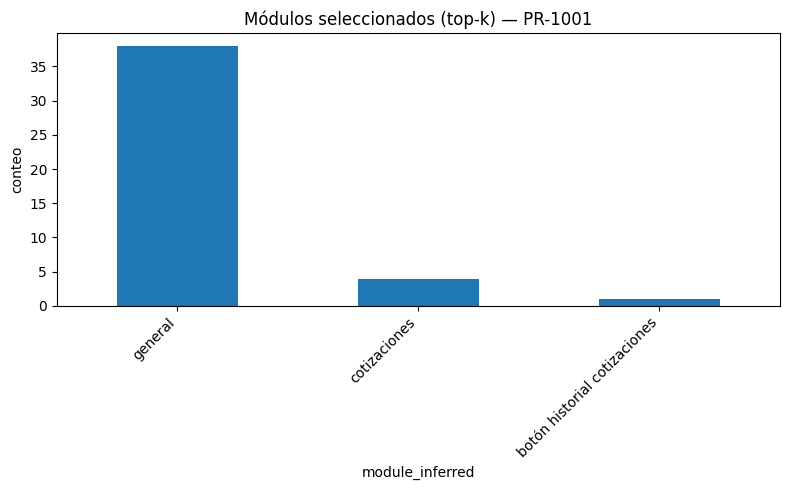

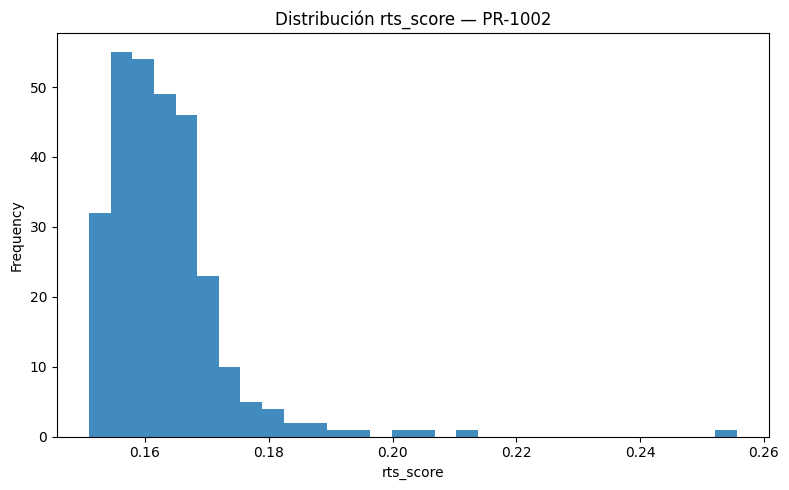

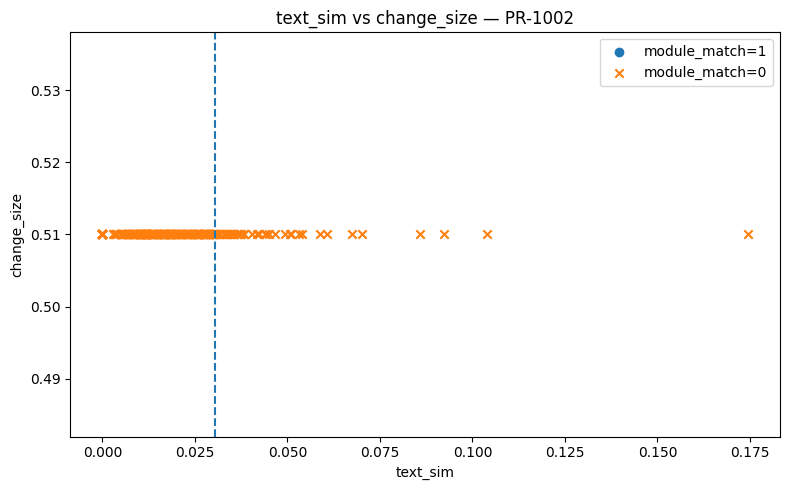

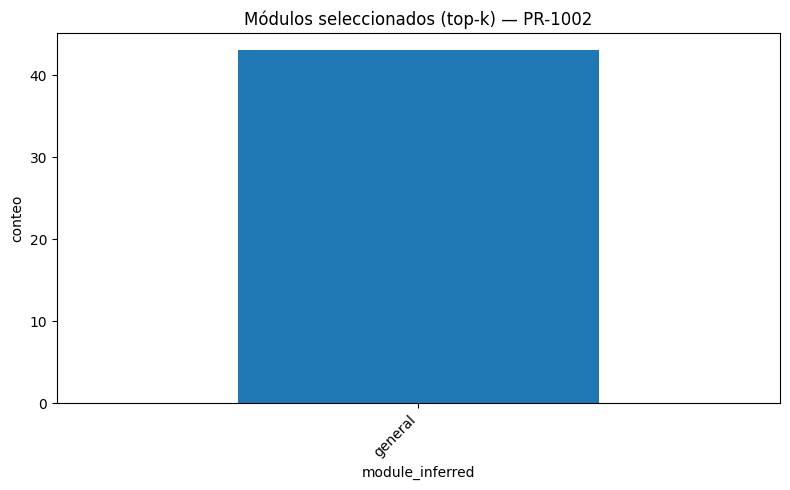

In [21]:
corpus_tests = df["text_full"].tolist()
corpus_prs = pr_docs["pr_text"].tolist()
vectorizer = TfidfVectorizer(max_features=CFG.TFIDF_MAX_FEATURES)
X = vectorizer.fit_transform(corpus_tests + corpus_prs)
X_tests = X[:len(corpus_tests)]
X_prs = X[len(corpus_tests):]

pr_index = {pid:i for i, pid in enumerate(pr_docs.index)}

def _severity_score(sev: str) -> float:
    sev = str(sev).lower()
    return {"critical":1.0,"high":0.7,"normal":0.3,"low":0.1}.get(sev, 0.3)

def rts_rank_for_pr(pr_id: str, top_frac: float = CFG.TOP_FRACTION) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
    if pr_id not in pr_index:
        raise ValueError(f"pr_id '{pr_id}' no encontrado. Disponibles: {list(pr_index)[:5]} ...")
    j = pr_index[pr_id]
    y = X_prs[j]                            # vector PR
    sim = (X_tests @ y.T).toarray().ravel() # coseno (TF-IDF tiene L2 por defecto)

    # módulo_match vectorizado
    changed_mods = set(map(str.lower, cf.loc[cf["pr_id"]==pr_id, "module"].dropna().astype(str)))
    module_match = df["module_inferred"].str.lower().isin(changed_mods).astype(float).values

    # riesgo + tamaño normalizado
    row = pr_docs.loc[pr_id]
    risk = _severity_score(row.get("severity_declared","normal"))
    if str(row.get("has_db_migration","no")).lower() in {"yes","si","true","1"}:
        risk += 0.2
    risk = float(min(1.0, max(0.0, risk)))
    change_size = float(min(1.0, row.get("total_lines_changed", 0) / CFG.LINES_NORM))

    # score final (sin bucles)
    score = CFG.W_SIM*sim + CFG.W_MODULE*module_match + CFG.W_RISK*risk + CFG.W_SIZE*change_size

    full = df[["case_id","title","module_inferred"]].copy()
    full["text_sim"] = sim
    full["module_match"] = module_match
    full["risk"] = risk
    full["change_size"] = change_size
    full["rts_score"] = score
    full = full.sort_values("rts_score", ascending=False, kind="mergesort").reset_index(drop=True)
    full["rank"] = full.index + 1

    k = max(5, int(len(full)*top_frac))
    selected = full.head(k).copy()
    threshold = float(selected["rts_score"].min())
    out_path = CFG.OUT_DIR / f"RTS_selected_{pr_id}.csv"
    selected.to_csv(out_path, index=False)
    print(f"[RTS] {pr_id}: top {k}/{len(full)} | umbral={threshold:.4f} -> {out_path}")
    return selected, full, threshold

# Ejemplos
sel_1001, full_1001, thr_1001 = rts_rank_for_pr("PR-1001")
sel_1002, full_1002, thr_1002 = rts_rank_for_pr("PR-1002")

# Diagnósticos compactos
def plot_rts(pr_id: str, selected: pd.DataFrame, full: pd.DataFrame, thr: float):
    if not CFG.MAKE_PLOTS: return
    hist(full["rts_score"], f"Distribución rts_score — {pr_id}", "rts_score")
    # scatter por módulo_match
    mm = full["module_match"].values
    x, y = full["text_sim"].values, full["change_size"].values
    plt.scatter(x[mm==1], y[mm==1], marker="o", label="module_match=1")
    plt.scatter(x[mm==0], y[mm==0], marker="x", label="module_match=0")
    plt.axvline(np.percentile(full["text_sim"], 85), linestyle="--")  # referencia soft
    plt.title(f"text_sim vs change_size — {pr_id}")
    plt.xlabel("text_sim"); plt.ylabel("change_size"); plt.legend(); plt.tight_layout(); plt.show()
    # cobertura módulos
    bar(selected["module_inferred"].value_counts().head(10), f"Módulos seleccionados (top-k) — {pr_id}", "module_inferred")

plot_rts("PR-1001", sel_1001, full_1001, thr_1001)
plot_rts("PR-1002", sel_1002, full_1002, thr_1002)


## 8) EVIDENCIAS RUN (compacto)

In [22]:
report = {
    "timestamp_utc": time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
    "python": sys.version,
    "platform": platform.platform(),
    "raw_sha256": sha256(CFG.RAW_TESTS),
    "changed_sha256": sha256(CFG.RAW_CHANGED),
    "meta_sha256": sha256(CFG.RAW_META),
    "processed_exists": (CFG.OUT_DIR / "TestCases_clean_features.csv").exists(),
    "df_shape": tuple(df.shape),
    "examples": ["PR-1001","PR-1002"]
}
with open(CFG.RUN_DIR / "run_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
with open(CFG.RUN_DIR / "RUN_OK.txt", "w", encoding="utf-8") as f:
    f.write("RTS run OK\n")
print("✔ Evidencias en run_artifacts/")

✔ Evidencias en run_artifacts/


# 9) Reporte final — Inventario inicial vs. selección RTS por PR

In [23]:
from datetime import datetime
from pathlib import Path

def _call_rts_selector(pr_id: str, top_frac=None):
    # Usa rts_rank_for_pr si existe; si no, rts_score_for_pr
    if 'rts_rank_for_pr' in globals():
        return rts_rank_for_pr(pr_id, top_frac if top_frac is not None else CFG.TOP_FRACTION)
    elif 'rts_score_for_pr' in globals():
        # Para compatibilidad con versiones previas que devuelven solo 'selected'
        res = rts_score_for_pr(pr_id, top_frac if top_frac is not None else CFG.TOP_FRACTION)
        if isinstance(res, tuple) and len(res) == 3:
            return res
        else:
            # Convertimos a tupla (selected, full, threshold) mínima
            selected = res
            full = selected  # fallback sin full/threshold reales
            thr = float(selected["rts_score"].min()) if "rts_score" in selected.columns and not selected.empty else 0.0
            return selected, full, thr
    else:
        raise NameError("No se encontró ninguna función RTS (rts_rank_for_pr / rts_score_for_pr).")

def build_rts_report(pr_ids=None, top_frac=None, preview=10):
    assert 'df' in globals(), "No se encontró 'df'."
    init_cols = [c for c in ['case_id','title','module_inferred','module','feature_name','sprint'] if c in df.columns]
    initial = df[init_cols].copy().sort_values(by=init_cols[0] if init_cols else 'case_id')
    print(f"[RTS-Reporte] Casos iniciales totales: {len(initial)}")
    display(initial.head(preview))

    if pr_ids is None:
        assert 'pr_docs' in globals(), "No se encontró 'pr_docs'."
        pr_ids = list(pr_docs.index)

    selected_all, resumen = [], []
    for pid in pr_ids:
        try:
            sel, full, thr = _call_rts_selector(pid, top_frac=top_frac)
            sel = sel.copy()
            sel.insert(0, "pr_id", pid)
            selected_all.append(sel)
            resumen.append((pid, len(sel)))
        except Exception as e:
            print(f"[WARN] Falló la selección para {pid}: {e}")

    if selected_all:
        selected_all = pd.concat(selected_all, ignore_index=True)
    else:
        selected_all = pd.DataFrame(columns=['pr_id'] + init_cols)

    print("\n[RTS-Reporte] Resumen por PR (nº de casos seleccionados):")
    resumen_df = pd.DataFrame(resumen, columns=['pr_id','selected_count']).sort_values('pr_id')
    display(resumen_df)

    print("\n[RTS-Reporte] Muestra de seleccionados (top-k por PR):")
    display(selected_all.groupby('pr_id').head(min(10, len(selected_all))) if not selected_all.empty else selected_all)

    out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
    stamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    initial_csv = out_dir / f"RTS_initial_{stamp}.csv"
    selected_csv = out_dir / f"RTS_selected_all_{stamp}.csv"
    xlsx = out_dir / f"RTS_report_{stamp}.xlsx"

    initial.to_csv(initial_csv, index=False)
    if not selected_all.empty:
        selected_all.to_csv(selected_csv, index=False)

    try:
        import pandas as _pd
        with pd.ExcelWriter(xlsx) as w:
            initial.to_excel(w, index=False, sheet_name="initial_cases")
            selected_all.to_excel(w, index=False, sheet_name="selected_all")
            for pid, g in selected_all.groupby('pr_id'):
                g.to_excel(w, index=False, sheet_name=f"sel_{str(pid)[:25]}")
        excel_ok = True
    except Exception as e:
        print(f"[INFO] Excel no disponible ({e}). Se guardaron CSV.")
        excel_ok = False

    not_selected = initial[~initial['case_id'].isin(selected_all['case_id'])] if not selected_all.empty else initial.copy()
    print(f"\n[RTS-Reporte] Casos NO seleccionados (conteo): {len(not_selected)}")
    display(not_selected.head(min(10, len(not_selected))))

    print("\n[RTS-Reporte] Archivos generados en:", out_dir.as_posix())
    print("  -", initial_csv.name)
    if not selected_all.empty:
        print("  -", selected_csv.name)
    if excel_ok:
        print("  -", xlsx.name)

    return initial, selected_all, resumen_df, not_selected

# Ejecuta:
initial_cases, selected_cases, summary_by_pr, not_selected = build_rts_report()



[RTS-Reporte] Casos iniciales totales: 288


,case_id,title,module_inferred,module,feature_name,sprint
4,1-HU-5612-1,Visualizar el botón Historial de cotizaciones ...,botón historial cotizaciones,Botón Historial Cotizaciones,Habilitar botón histórico de cotizaciones el e...,7.0
5,1-HU-5612-2,Ver los tooltips de los botones del HeaderVer ...,tooltips,Tooltips,Habilitar botón histórico de cotizaciones el e...,7.0
0,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
13,1-HU1-1,Visualización de la opción 'Cotización' en el ...,general,General,Ingresar al módulo de cotizaciones,1.0
1,1-HU1-2,Redirección a la página de Cotizaciones al hac...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
14,1-HU1-2,Redirección a la página de Cotizaciones al hac...,general,General,Ingresar al módulo de cotizaciones,1.0
2,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
15,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,general,General,Ingresar al módulo de cotizaciones,1.0
3,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
16,1-HU1-4,Contenido correcto en la página de Cotizacione...,general,General,Ingresar al módulo de cotizaciones,1.0


[RTS] PR-1001: top 43/288 | umbral=0.1644 -> ..\data\processed\RTS_selected_PR-1001.csv
[RTS] PR-1002: top 43/288 | umbral=0.1693 -> ..\data\processed\RTS_selected_PR-1002.csv
[RTS] PR-1003: top 43/288 | umbral=0.0818 -> ..\data\processed\RTS_selected_PR-1003.csv

[RTS-Reporte] Resumen por PR (nº de casos seleccionados):


,pr_id,selected_count
0,PR-1001,43
1,PR-1002,43
2,PR-1003,43



[RTS-Reporte] Muestra de seleccionados (top-k por PR):


,pr_id,case_id,title,module_inferred,text_sim,module_match,risk,change_size,rts_score,rank
0,PR-1001,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,0.157435,1.0,0.3,0.983333,0.422794,1
1,PR-1001,1-HU1-2,Redirección a la página de Cotizaciones al hac...,cotizaciones,0.151914,1.0,0.3,0.983333,0.419482,2
2,PR-1001,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,cotizaciones,0.114566,1.0,0.3,0.983333,0.397073,3
3,PR-1001,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,0.017876,1.0,0.3,0.983333,0.339059,4
4,PR-1001,6040,Visualización de cotizaciones del cliente prin...,general,0.196435,0.0,0.3,0.983333,0.246194,5
5,PR-1001,1-HU2-6,Visualización de rangos de precios en las cate...,general,0.171400,0.0,0.3,0.983333,0.231173,6
6,PR-1001,3-HU3-2,Cálculo correcto del total en el resumen,general,0.162976,0.0,0.3,0.983333,0.226119,7
7,PR-1001,6040,Filtrar cotizaciones por semana,general,0.158327,0.0,0.3,0.983333,0.223329,8
8,PR-1001,6040,Filtrar cotizaciones por una fecha específica,general,0.158219,0.0,0.3,0.983333,0.223265,9
9,PR-1001,6040,Filtrar cotizaciones por mes,general,0.158063,0.0,0.3,0.983333,0.223171,10



[RTS-Reporte] Casos NO seleccionados (conteo): 180


,case_id,title,module_inferred,module,feature_name,sprint
5,1-HU-5612-2,Ver los tooltips de los botones del HeaderVer ...,tooltips,Tooltips,Habilitar botón histórico de cotizaciones el e...,7.0
6,1. HU 6217-1,Activar botonEliminar Productos,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
7,1. HU 6217-2,Activar boton Activar Notificaciones,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
8,1. HU 6217-3,Activar boton Desactivar Notificaciones,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
9,1. HU 6217-4,Eliminar producto desde el ícono en la columna...,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
10,1. HU 6217-5,Activar boton Eliminar Productos y Agregar al ...,gestionar mi lista de espera - disponibles,Gestionar Mi lista de espera - Disponibles,Botones en gestionar mi ista de espera,8.0
11,1. HU 6217-6,Eliminar producto en la pestaña Disponibles,gestionar mi lista de espera - disponibles,Gestionar Mi lista de espera - Disponibles,Botones en gestionar mi ista de espera,8.0
12,1. HU 6217-7,Agregar al carrito desde la pestaña Disponibles,gestionar mi lista de espera - disponibles,Gestionar Mi lista de espera - Disponibles,Botones en gestionar mi ista de espera,8.0
42,2-HU1-10,Fallo al intentar agregar más productos que el...,general,General,Agregar productos al carrito,2.0
43,2-HU1-11,Error al visualizar el carrito sin conexión a ...,general,General,Agregar productos al carrito,2.0



[RTS-Reporte] Archivos generados en: ../data/processed
  - RTS_initial_20251005T224711Z.csv
  - RTS_selected_all_20251005T224711Z.csv
  - RTS_report_20251005T224711Z.xlsx


# AVANCE 2: Ingeniería de Características (Feature Engineering (FE))

El propósito de esta fase fue convertir los datos crudos en un conjunto  de variables relevantes para modelos de Regression Test Selection (RTS.)

Nuevas features, codificación, discretización, escalamiento, transformaciones.

## A. Operaciones de procesamiento

Se contruyó un conjunto de datos de pares (PR x Caso) que combina información textual, los cuales abarcan los campos descriptivos de los casos de prueba (título, pasos, resultados, observaciones), con información estructural, relacionada con los cambios técnicos de los PR (líneas modificadas, severidad, entre otros.)

La información textual se representa mediante un modelo TF-IDF (Term Frequency-Inverse Document Frequency), que permite medir la similitud entre los textos de casos y PRs. En conjunto, se generan señales más completas para la priorización de pruebas dentro del ciclo de calidad.


Nota: TF-IDF permite asignar un peso respecto a lo relevante que es una palabra.

In [31]:
# =========================
# FE-1) Pares PR × Caso (señales para RTS)
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

assert 'df' in globals(), "No se encontró df (casos)."
assert 'pr_docs' in globals(), "No se encontró pr_docs (documentos por PR)."

# Asegura texto y vectorizador (compartido tests+PR)
if "text_full" not in df.columns:
    TEXT_COLS = ["title","preconditions","steps","expected_result","obtained_result","observations"]
    for c in TEXT_COLS:
        if c not in df.columns: df[c] = ""
    df["text_full"] = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)

if 'vectorizer' not in globals() or 'X_tests' not in globals() or 'X_prs' not in globals():
    vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2), sublinear_tf=True)
    X = vectorizer.fit_transform(df["text_full"].tolist() + pr_docs["pr_text"].tolist())
    X_tests = X[:len(df)]
    X_prs   = X[len(df):]

# Similitudes de una sola pasada (matriz casos×PR)
S = (X_tests @ X_prs.T).toarray()
pr_ids = list(pr_docs.index)
n_cases, n_prs = S.shape

# Señales por PR
changed_mods = {pid: set(map(str.lower, cf.loc[cf["pr_id"]==pid, "module"].dropna().astype(str))) for pid in pr_ids}
mods_cases = df["module_inferred"].astype(str).str.lower().values

module_match_mat = np.zeros((n_cases, n_prs), dtype=float)
for j, pid in enumerate(pr_ids):
    module_match_mat[:, j] = np.isin(mods_cases, list(changed_mods.get(pid, set()))).astype(float)

risk_arr = []
chg_size_arr = []
sev_lbl = []
dbmig_arr = []
mod_touched_arr = []
lines_changed_arr = []
for pid in pr_ids:
    row = pr_docs.loc[pid]
    sev = str(row.get("severity_declared","normal")).lower()
    risk = {"critical":1.0,"high":0.7,"normal":0.3,"low":0.1}.get(sev,0.3)
    if str(row.get("has_db_migration","no")).lower() in {"yes","si","true","1"}:
        risk += 0.2
    risk_arr.append(min(1.0,max(0.0,risk)))
    lines = float(row.get("total_lines_changed", 0))
    chg_size_arr.append(min(1.0, lines / 300.0))
    sev_lbl.append(sev)
    dbmig_arr.append(str(row.get("has_db_migration","no")).lower())
    mod_touched_arr.append(len(changed_mods.get(pid, set())))
    lines_changed_arr.append(lines)

risk_arr = np.array(risk_arr); chg_size_arr = np.array(chg_size_arr)
sev_lbl  = np.array(sev_lbl);  dbmig_arr   = np.array(dbmig_arr)
mod_touched_arr = np.array(mod_touched_arr); lines_changed_arr = np.array(lines_changed_arr)

# Umbrales adaptativos por PR (cuantil 85) para proxy de "relevante"
thr = np.quantile(S, 0.85, axis=0)
proxy_sel = ((S >= thr) | (module_match_mat == 1.0)).astype(int)

# Armado del dataset de pares (PR×Caso)
pairs = pd.DataFrame({
    "pr_id":          np.repeat(pr_ids, n_cases),
    "case_id":        np.tile(df["case_id"].values, n_prs),
    "module_inferred":np.tile(df["module_inferred"].astype(str).values, n_prs),
    "text_sim":       S.T.ravel(),
    "module_match":   module_match_mat.T.ravel(),
    "risk":           np.repeat(risk_arr, n_cases),
    "change_size":    np.repeat(chg_size_arr, n_cases),
    "severity_declared": np.repeat(sev_lbl, n_cases),
    "has_db_migration":  np.repeat(dbmig_arr, n_cases),
    "modules_touched_count": np.repeat(mod_touched_arr, n_cases),
    "total_lines_changed":   np.repeat(lines_changed_arr, n_cases),
    "exec_count":     np.tile(df.get("exec_count", pd.Series(0, index=df.index)).fillna(0).values, n_prs),
    "title_len":      np.tile(df.get("title_len", pd.Series(0, index=df.index)).values, n_prs),
    "steps_len":      np.tile(df.get("steps_len", pd.Series(0, index=df.index)).values, n_prs),
    "expected_result_len": np.tile(df.get("expected_result_len", pd.Series(0, index=df.index)).values, n_prs),
})
pairs["y_proxy_selected"] = proxy_sel.T.ravel().astype(int)  # objetivo proxy, útil para filtros supervisados

# Persistencia
out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
pairs_path = out_dir / "RTS_pairs_FE_raw.csv"
pairs.to_csv(pairs_path, index=False)
print(f"[FE] Dataset pares guardado: {pairs_path} | shape={pairs.shape}")
display(pairs.head(8))


[FE] Dataset pares guardado: ..\data\processed\RTS_pairs_FE_raw.csv | shape=(864, 16)


,pr_id,case_id,module_inferred,text_sim,module_match,risk,change_size,severity_declared,has_db_migration,modules_touched_count,total_lines_changed,exec_count,title_len,steps_len,expected_result_len,y_proxy_selected
0,PR-1001,1-HU1-1,cotizaciones,0.017876,1.0,0.3,0.983333,normal,no,1,295.0,3.0,102,200,66,1
1,PR-1001,1-HU1-2,cotizaciones,0.151914,1.0,0.3,0.983333,normal,no,1,295.0,3.0,69,59,67,1
2,PR-1001,1-HU1-3,cotizaciones,0.114566,1.0,0.3,0.983333,normal,no,1,295.0,2.0,55,59,87,1
3,PR-1001,1-HU1-4,cotizaciones,0.157435,1.0,0.3,0.983333,normal,no,1,295.0,3.0,67,113,64,1
4,PR-1001,1-HU-5612-1,botón historial cotizaciones,0.105479,0.0,0.3,0.983333,normal,no,1,295.0,1.0,70,216,136,1
5,PR-1001,1-HU-5612-2,tooltips,0.039460,0.0,0.3,0.983333,normal,no,1,295.0,1.0,84,249,99,0
6,PR-1001,1. HU 6217-1,gestionar mi lista de espera - no disponibles,0.028815,0.0,0.3,0.983333,normal,no,1,295.0,1.0,31,355,0,0
7,PR-1001,1. HU 6217-2,gestionar mi lista de espera - no disponibles,0.024919,0.0,0.3,0.983333,normal,no,1,295.0,1.0,36,360,0,0


# Transformaciones y codificación

Una vez generado el dataset de pares, se aplicaron técnicas de Discretización (binning), transformaciones (Yeo-Johnson), escalado no-negativo (MaxAbs) para preparar los datos. Estas operaciones permiten estabilizar la varianza, eliminar sesgos y asegurar que las variables sean comparables entre ellas.

### Justificación

Las transformaciones aplicadas fueron:
* Yeo-Johnson:
Transforma las variables númericas reduciendo la asimetría y estabilizando la varianza, compatible con valores ceros o negativos.

* MaxAbsScaler: 
Evita la aparición de valores negativos, asegurando la compatibilidad con métricas estadísticas como χ².

* KBins:
Robustece valores  atípicos y ayuda a modelos lineales a captar relaciones no-lineales.

* One-Hot Encoding:
Transforma las categorías en variables binarias independientes, asegurando que el modelo no interprete una relación de orden entre ellas.

Estas transformaciones tiene como objetivo garantizar una matriz de características homogénea, sin valores negativos ni redundancias, que permitan aplicar los métodos de selección y evaluación de características.

In [32]:
# =========================
# FE-2) Discretización, transformaciones y codificación (FIX)
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# 1) Definición de columnas base
num_basic = [
    "text_sim","module_match","risk","change_size",
    "exec_count","title_len","steps_len","expected_result_len",
    "modules_touched_count","total_lines_changed"
]
# Columnas que queremos también en versión "binned"
bin_src = {"text_sim": "text_sim_bin_src", "change_size": "change_size_bin_src"}
cat_cols = ["module_inferred","severity_declared","has_db_migration","pr_id"]  # pr_id útil si modelas por PR

# 2) Clonar columnas para binning (con nombres distintos)
pairs_ext = pairs.copy()
for src, dup in bin_src.items():
    if src in pairs_ext.columns:
        pairs_ext[dup] = pairs_ext[src]

bin_cols = list(bin_src.values())

# 3) Mantener solo columnas existentes (por si faltan algunas en tus datos)
def existing(cols, frame): 
    return [c for c in cols if c in frame.columns]

num_basic = existing(num_basic, pairs_ext)
bin_cols  = existing(bin_cols,  pairs_ext)
cat_cols  = existing(cat_cols,  pairs_ext)

# 4) Pipelines por tipo
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("power",   PowerTransformer(method="yeo-johnson", standardize=False)),  # mitiga asimetría
    ("scale",   MinMaxScaler())   # asegura [0,1] -> χ² OK
])

bin_pipe = KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile")
cat_pipe = OneHotEncoder(handle_unknown="ignore")

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_basic),
        ("bin", bin_pipe, bin_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# 5) Deduplicar columnas en el slicing (evita el error de columnas no únicas)
all_cols = list(dict.fromkeys(num_basic + bin_cols + cat_cols))
X = pre.fit_transform(pairs_ext[all_cols])
y = pairs_ext["y_proxy_selected"].values

# 6) Nombres de features
try:
    feat_names = pre.get_feature_names_out()
except Exception:
    feat_names = np.array([f"f_{i}" for i in range(X.shape[1])])

# 7) Sanidad para χ²: verificar no-negatividad
from scipy import sparse
if sparse.issparse(X):
    min_val = X.min()
else:
    min_val = np.min(X)
assert min_val >= 0, "La matriz transformada contiene valores negativos; revisa el pipeline de escalado."

print("[FE] Matriz X lista para selección:", X.shape, "| y:", y.shape)


[FE] Matriz X lista para selección: (864, 32) | y: (864,)


# B. Selección de características (filtros + extracción)

Ahora bien, se aplican métodos para eliminar redudancias y conservar las variables más relevantes del conjunto de datos: VarianceThreshold, correlación (numéricas originales), ANOVA (f_classif), χ² y SVD/PCA (para reducción). Todo fundamentado y exportado.

### Justificación (2.4)

* VarianceThreshold: Elimina características sin información (p. ej., OHE raras).

* Correlación (>0.95): Reduce multicolinealidad en numéricas.

* ANOVA (f_classif) y χ²: Priorizan features con mayor poder discriminativo usando la etiqueta proxy (y_proxy_selected).

* Reducción dimensional (SVD/PCA): Aceleran entrenamientos al condensar información a menos componentes.

Con esto se obtiene un conjunto de características más compacto, representativo y listo para la fase de modelado.

In [27]:
# =========================
# FE-3) Filtros: varianza y correlación (numéricas originales)
# =========================
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 3.1 Varianza ~0 (en X transformada)
vt = VarianceThreshold(threshold=1e-9)
X_vt = vt.fit_transform(X)
mask_vt = vt.get_support()
names_vt = feat_names[mask_vt]
print(f"[SEL] VarianceThreshold: {X.shape[1]} -> {X_vt.shape[1]}")

# 3.2 Correlación alta (solo numéricas *originales* antes de OHE/BIN)
num_df = pairs[num_basic].copy()
corr = num_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
print(f"[SEL] Correlación>0.95 (numéricas): drop {to_drop}")
num_keep = [c for c in num_basic if c not in to_drop]


[SEL] VarianceThreshold: 32 -> 31
[SEL] Correlación>0.95 (numéricas): drop ['total_lines_changed']


In [28]:
# =========================
# FE-4) Selección supervisada: ANOVA (F) y χ² con y_proxy
# =========================
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from scipy import sparse

# Por simplicidad aplicamos SelectKBest sobre TODA la X depurada por varianza.
# ANOVA F (admite negativos, pero ya tenemos no-negativo por MaxAbs)
k_anova = min(100, X_vt.shape[1])
sel_f = SelectKBest(score_func=f_classif, k=k_anova).fit(X_vt, y)
scores_f = pd.Series(sel_f.scores_, index=names_vt).sort_values(ascending=False)

# χ² (requiere no-negativos; ya cumplimos)
k_chi2 = min(100, X_vt.shape[1])
sel_chi = SelectKBest(score_func=chi2, k=k_chi2).fit(X_vt, y)
scores_chi = pd.Series(sel_chi.scores_, index=names_vt).sort_values(ascending=False)

top_f   = scores_f.head(30)
top_chi = scores_chi.head(30)
print("[SEL] Top30 ANOVA F:\n", top_f.head(10))
print("\n[SEL] Top30 Chi2:\n", top_chi.head(10))


[SEL] Top30 ANOVA F:
 bin__text_sim_bin_src_4.0            849.192663
num__text_sim                        699.816679
bin__text_sim_bin_src_1.0             41.523048
bin__text_sim_bin_src_0.0             41.523048
bin__text_sim_bin_src_2.0             38.043550
cat__module_inferred_cotizaciones     34.087133
num__module_match                     22.409544
num__title_len                        15.368226
num__exec_count                        5.095189
num__expected_result_len               5.022848
dtype: float64

[SEL] Top30 Chi2:
 bin__text_sim_bin_src_4.0                                             342.914122
num__text_sim                                                          45.989701
cat__module_inferred_cotizaciones                                      32.410059
bin__text_sim_bin_src_1.0                                              31.756164
bin__text_sim_bin_src_0.0                                              31.756164
bin__text_sim_bin_src_2.0                                 

In [29]:
# =========================
# FE-5) Extracción (dimensionalidad)
# =========================
from sklearn.decomposition import TruncatedSVD, PCA

# 5.1 SVD (funciona bien con matrices dispersas: mezcla num/bin/ohe)
svd_k = min(50, X_vt.shape[1]-1) if X_vt.shape[1] > 1 else 1
svd = TruncatedSVD(n_components=svd_k, random_state=42)
X_svd = svd.fit_transform(X_vt)
print(f"[SVD] Componentes: {svd_k} | Var. explicada acumulada: {svd.explained_variance_ratio_.sum():.3f}")

# 5.2 PCA solo sobre numéricas continuas (si quieres análisis adicional)
X_num = num_df[num_keep].to_numpy()
if X_num.shape[1] >= 2:
    from sklearn.preprocessing import StandardScaler
    Xn = StandardScaler().fit_transform(X_num)
    pca = PCA(n_components=min(5, Xn.shape[1]), random_state=42)
    X_pca = pca.fit_transform(Xn)
    print(f"[PCA] Componentes: {pca.n_components_} | Var. explicada: {pca.explained_variance_ratio_.sum():.3f}")


[SVD] Componentes: 30 | Var. explicada acumulada: 1.000
[PCA] Componentes: 5 | Var. explicada: 0.740


In [30]:
# =========================
# FE-6) Export y evidencia
# =========================
from pathlib import Path
out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)

# Reportes
scores_f.to_csv(out_dir / "FE_scores_ANOVA.csv")
scores_chi.to_csv(out_dir / "FE_scores_Chi2.csv")
pd.Series(names_vt).to_csv(out_dir / "FE_features_after_variance.csv", index=False)

# Matrices reducidas (tamaños moderados); si es grande, omite CSV y usa joblib
pd.DataFrame(X_svd).to_csv(out_dir / "FE_SVD_components.csv", index=False)
if 'X_pca' in globals():
    pd.DataFrame(X_pca).to_csv(out_dir / "FE_PCA_num.csv", index=False)

print("✔ FE exportada en:", out_dir.as_posix())


✔ FE exportada en: ../data/processed


# Conclusiones — Preparación de los datos (CRISP-ML)

Objetivo de negocio: Acelerar el aseguramiento de calidad (QA) enfocando pruebas relevantes por PR (RTS) en el proyecto de metalurgia para construcción, optimizando así el tiempo de entrega en los pipelines CI/CD.

### Datos y comprensión:

Fuentes: TestCases.csv, ChangedFiles.csv, PipelineMeta.csv.

Calidad: textos heterogéneos; categorías con alias; fuerte desbalance por módulo (ej.: muchos de Cotizaciones).

### Preparación:

Normalización y alias de columnas; estados de prueba estandarizados.

Heurística de módulo (module_inferred).

Documento por PR con tokens de rutas, módulos tocados y riesgo.

### Ingeniería de señales (FE) a nivel PR×Caso:

text_sim, module_match, risk, change_size, longitudes, modules_touched_count, etc.

Transformaciones: Yeo-Johnson (asimetría), binning por cuantiles, MaxAbs (χ²).

Codificación: one-hot de categorías y PR.

### Selección/Extracción:

Filtros: varianza≈0, correlación>0.95.

Supervisado con proxy: ANOVA y χ² sobre y_proxy_selected.

Reducción: SVD (matrices dispersas), PCA (numéricas).

### Riesgos de sesgo y mitigación (2.4):

Desbalance por módulo → usar TOP_FRACTION dinámico y mínimo por módulo impactado; evaluar con stratified sampling.

Riesgo global igual para todas las filas del PR → mantenerlo, pero no dejar que domine (peso moderado).

Etiquetas proxy → reemplazar por histórico real cuando esté disponible; mientras, usa múltiples cuantiles (p. ej., 80/85/90) para sensibilidad.

### Siguiente paso (Modelación/RTS):

Entrenar un clasificador sobre pares PR×Caso (objetivo real cuando exista; por ahora y_proxy_selected) y comparar contra el ranking heurístico actual.

Integrarlo al pipeline CI como etapa opcional: si severity=critical o has_db_migration=yes, aumentar cobertura.